In [224]:
#import libraries
import numpy as np
from pathlib import Path
import pandas as pd
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor,GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, Matern
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import svm
from sklearn.model_selection import GridSearchCV


In [225]:
# Read 7D dataset 
df_in_7d = pd.read_csv('data/supercompressible_7d_input.csv')
df_out_7d = pd.read_csv('data/supercompressible_7d_output.csv')

# Read 3D dataset 
df_in_3d = pd.read_csv('data/supercompressible_3d_input.csv')
df_out_3d = pd.read_csv('data/supercompressible_3d_output.csv')

In [226]:
# define a function to do the preprocessing
# Input: input_raw_data, output_raw_data, problem_class
# input_raw_data: pandas dataframe for input
# output_raw_data: pandas dataframe for output
# problem_class: (booler) to describe this preprocess is for classification problem or not
#                this will lead to different scaler for Y data.
#
# Output: X_train_scale, X_test_scale, X_scale, Y_train_scale, Y_test_scale, Y_scale, scaler_x, scaler_y
# scaler_x: (scaler) used to do inverse_transfer after prediction
# scaler_y: (scaler) used to do inverse_transfer after prediction

def preprocess_3d(input_raw_data,output_raw_data,problem_class):
    if problem_class == False: # regression problem's preprocess
        raw_data = pd.concat([input_raw_data, output_raw_data], axis=1)
        raw_data_drop_nan = raw_data.dropna() # drop those points whose

        X_3d = raw_data_drop_nan.loc[:, ['ratio_d','ratio_pitch','ratio_top_diameter'] ].values
        Y_3d = raw_data_drop_nan.loc[:, ['sigma_crit','energy'] ].values
        
        testset_ratio = 0.25
        SEED = 123
        X_train, X_test, Y_train, Y_test = train_test_split(X_3d,
                                            Y_3d, test_size=testset_ratio,
                                            random_state=SEED)

        scaler_x = StandardScaler()
        scaler_x.fit(X_train)
        X_train_scale=scaler_x.transform(X_train)
        X_test_scale=scaler_x.transform(X_test)
        X_scale=scaler_x.transform(X_3d)
        
        scaler_y = StandardScaler()
        scaler_y.fit(Y_train)
        Y_train_scale = scaler_y.transform(Y_train)
        Y_test_scale = scaler_y.transform(Y_test)
        Y_scale = scaler_y.transform(Y_3d)
    else: # classification problem's preprocess
        X_3d = input_raw_data.loc[:, ['ratio_d','ratio_pitch','ratio_top_diameter'] ].values
        Y_3d = output_raw_data.loc[:, 'coilable'].values
        
        testset_ratio = 0.25
        SEED = 123
        X_train, X_test, Y_train, Y_test = train_test_split(X_3d,
                                            Y_3d, test_size=testset_ratio,
                                            random_state=SEED)

        scaler_x = StandardScaler()
        scaler_x.fit(X_train)
        X_train_scale=scaler_x.transform(X_train)
        X_test_scale=scaler_x.transform(X_test)
        X_scale=scaler_x.transform(X_3d)

        scaler_y = FunctionTransformer() # FunctionTransformer without input will give a Identity scaler
        Y_train_scale = scaler_y.transform(Y_train)
        Y_test_scale = scaler_y.transform(Y_test)
        Y_scale = scaler_y.transform(Y_3d)

    return X_train_scale, X_test_scale, X_scale, Y_train_scale, Y_test_scale, Y_scale, scaler_x, scaler_y

In [227]:
X_train_scale_class, X_test_scale_class, X_scale_class, Y_train_scale_class, Y_test_scale_class, Y_scale_class, scaler_x_class, scaler_y_class = preprocess_3d(df_in_3d,df_out_3d,True)
X_train_scale_regression, X_test_scale_regression, X_scale_regression, Y_train_scale_regression, Y_test_scale_regression, Y_scale_regression, scaler_x_regression, scaler_y_regression = preprocess_3d(df_in_3d,df_out_3d,False)

In [228]:
# Define function to do the model training and predicting
# Input: X_train,X_test,X_data,Y_train,Y_test,Y_data,scaler_x, scaler_y,model
# X_train,X_test,X_data,Y_train,Y_test,Y_data,scaler_x, scaler_y,: scaled data set for classification
# model: any model for predict classification problem
#
# Output: ac_score,pr_score,re_score,f_one_score,con_matrix
# ac_score: accuracy_score with test sample
# pr_score: precision_score with test sample
# re_score: recall_score with test sample
# f_one_score: f1_score with test sample
# con_matrix: confusion_matrix with test sample 

def classification_model_train_and_predict(X_train,X_test,X_data,Y_train,Y_test,Y_data,scaler_x, scaler_y,model):
    model.fit(X_train,Y_train)
    Y_predict_for_test = model.predict(X_test)
    ac_score = accuracy_score(Y_test,Y_predict_for_test)
    pr_score = precision_score(Y_test,Y_predict_for_test,average=None)
    re_score = recall_score(Y_test,Y_predict_for_test,average=None)
    f_one_score = f1_score(Y_test,Y_predict_for_test,average=None)
    con_matrix = confusion_matrix(Y_test,Y_predict_for_test)

    #classification_model_plot(X_data,Y_data,scaler_x, scaler_y,model,249,20)
    # this function is not necessary for Part4

    return ac_score,pr_score,re_score,f_one_score,con_matrix

In [229]:
# Define SVM model
svm_model = svm.SVC(kernel='rbf')

# Set up the parameter grid
parameter_grid = {'C': [50,80,100,200,1000,10000], 
                  'gamma': [0.75, 0.8, 0.85, 0.9, 0.95, 1]}

# Configure GridSearchCV
grid_search = GridSearchCV(svm_model, parameter_grid, cv=5)

# Fit the grid search model
grid_search.fit(X_train_scale_class, Y_train_scale_class)

# Find the best parameters and score
best_parameters = grid_search.best_params_
best_score = grid_search.best_score_

# Create and fit the optimal model
optimal_model = svm.SVC(kernel='rbf', C=best_parameters['C'], gamma=best_parameters['gamma'])

ac_score,pr_score,re_score,f_one_score,con_matrix = classification_model_train_and_predict(X_train_scale_class, X_test_scale_class, X_scale_class, Y_train_scale_class, Y_test_scale_class, Y_scale_class,scaler_x_class, scaler_y_class,optimal_model)
print(ac_score)
print(pr_score)
print(re_score)
print(f_one_score)
print(con_matrix)
print(best_parameters)

0.852
[0.92307692 0.74468085 0.848     ]
[0.92307692 0.66037736 0.8907563 ]
[0.92307692 0.7        0.86885246]
[[ 72   3   3]
 [  2  35  16]
 [  4   9 106]]
{'C': 100, 'gamma': 0.8}


In [230]:
# Define function to do the model training and predicting
# Input: X_train,X_test,X_data,Y_train,Y_test,Y_data,scaler_x, scaler_y,model
# X_train,X_test,X_data,Y_train,Y_test,Y_data,scaler_x, scaler_y,: scaled data set for classification
# model: any model for regression problem
#
# Output: r2, mse
# r2: r2_score with test sample of trianing and testing result
# mse: mean squared error of trianing and testing result


def regression_model_train_and_predict(X_train,X_test,X_data,Y_train,Y_test,Y_data,scaler_x,scaler_y,model):
    model.fit(X_train,Y_train)
    Y_predict_for_test = model.predict(X_test)
    r2 = r2_score(Y_test,Y_predict_for_test)
    mse = mean_squared_error(Y_test,Y_predict_for_test)

    # regression_model_plot(X_data,Y_data,scaler_x,scaler_y,model,5,10,True)
    # this function is not necessary in Part4

    return r2, mse

In [231]:
kernel = Matern(length_scale=1.0, length_scale_bounds=(1e-5, 1e5),nu=2.5)
gpr_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=20)

r2, mse = regression_model_train_and_predict(X_train_scale_regression, X_test_scale_regression, X_scale_regression, Y_train_scale_regression, Y_test_scale_regression, Y_scale_regression,scaler_x_regression, scaler_y_regression,gpr_model)

print(r2)
print(mse)

0.9993278047777601
0.0006239489505652623


## search for the optimum points

In [232]:
def find_best_point_in_dataset(X_data,Y_data,scaler_x_regression,scaler_x_class, scaler_y,class_model,regression_model):
    X_data_not_scale = scaler_x_regression.inverse_transform(X_data)
    X_scale_class = scaler_x_class.transform(X_data_not_scale)
    y_class_pred = class_model.predict(X_scale_class)
    coilable_points_x = []
    coilable_points_y = []

    X_data_inverse = scaler_x_regression.inverse_transform(X_data)
    Y_data_inverse = scaler_y.inverse_transform(Y_data)
    for class_pred_index in range(len(y_class_pred)):
        if y_class_pred[class_pred_index] == 1:
            coilable_points_x.append(X_data_inverse[class_pred_index,:])
            coilable_points_y.append(Y_data_inverse[class_pred_index,:])
            
    best_simga = coilable_points_y[0][0]
    best_sigma_index = 0
    best_energy = coilable_points_y[0][1]
    best_energy_index = 0

    # search best points
    for index in range(len(coilable_points_x)):
        if coilable_points_y[index][0] > best_simga:
            best_sigma = coilable_points_y[index][0]
            best_sigma_index = index
        if coilable_points_y[index][1] > best_energy:
            best_energy = coilable_points_y[index][1]
            best_energy_index = index

    best_sigma_input = coilable_points_x[best_sigma_index]
    best_energy_input = coilable_points_x[best_energy_index]

    return best_sigma,best_energy,best_sigma_input,best_energy_input
    


In [233]:
best_sigma,best_energy,best_sigma_input,best_energy_input = find_best_point_in_dataset(X_scale_regression,Y_scale_regression,scaler_x_regression,scaler_x_class,scaler_y_regression,optimal_model,gpr_model)
print(best_sigma)
print(best_energy)
print(best_sigma_input)
print(best_energy_input)

4.968689999374499
3.7321415827498914
[0.03209863 0.44897461 0.66484375]
[0.0337832  0.32080078 0.7578125 ]


## different optimization algorithms

In [234]:
import numpy as np
from scipy.optimize import minimize 
#import gpyopt.methods

svc = optimal_model  # trained SVC model
gpr = gpr_model  # trained GPR model with Matern kernel

global sigma_converge_space_NM
sigma_converge_space_NM = []
global energy_converge_space_NM
energy_converge_space_NM = []


def objective_function(x, target_output):
    # Ensure that the input is classified as '1' by the SVC
    x_scale_class = scaler_x_class.transform([x])
    x_scale = scaler_x_regression.transform([x])

    if svc.predict(x_scale_class) != 1:
        return float('inf')
        # return 100000
    
    # Predict with GPR and get the desired output
    gpr_result = gpr.predict(x_scale, return_std=False)
    result = scaler_y_regression.inverse_transform(gpr_result)
    sigma = result[0][0]
    energy = result[0][1]
    if target_output == 'sigma':
        sigma_converge_space_NM.append(sigma)
        return -sigma  # Negative because we are using a minimization function
    elif target_output == 'energy':
        energy_converge_space_NM.append(energy)
        return -energy

# Initial guess for the optimizer
initial_guess_sigma = best_sigma_input
initial_guess_energy = best_energy_input 

# Optimize for sigma
result_sigma = minimize(objective_function, initial_guess_sigma, args=('sigma',), method='Nelder-Mead',options={'disp': True} )
optimal_sigma = -result_sigma.fun  # Negate because we minimized the negative sigma
optimal_sigma_input = result_sigma.x

# Optimize for energy
result_energy = minimize(objective_function, initial_guess_energy, args=('energy',), method='Nelder-Mead',options={'disp': True} )
optimal_energy = -result_energy.fun  # Negate because we minimized the negative energy
optimal_energy_input = result_energy.x


print("Optimal Sigma:", optimal_sigma)
print("Optimal Sigma inputs:", optimal_sigma_input)

print("Optimal Energy:", optimal_energy)
print("Optimal Energy inputs:", optimal_energy_input)



Optimization terminated successfully.
         Current function value: -96.189750
         Iterations: 118
         Function evaluations: 225
Optimization terminated successfully.
         Current function value: -47.588573
         Iterations: 268
         Function evaluations: 506
Optimal Sigma: 96.18975032876452
Optimal Sigma inputs: [0.06518625 0.65850596 0.69536677]
Optimal Energy: 47.588572992520625
Optimal Energy inputs: [0.06279879 0.68555789 0.66930202]


In [235]:
import numpy as np
from scipy.optimize import minimize 
#import gpyopt.methods

# Assuming you have trained your SVC and GPR models already
svc = optimal_model  # trained SVC model
gpr = gpr_model  # trained GPR model with Matern kernel

global sigma_converge_space_BFGS
sigma_converge_space_BFGS = []
global energy_converge_space_BFGS
energy_converge_space_BFGS = []


def objective_function(x, target_output):
    # Ensure that the input is classified as '1' by the SVC
    x_scale_class = scaler_x_class.transform([x])
    x_scale = scaler_x_regression.transform([x])

    if svc.predict(x_scale_class) != 1:
        return 10000
    
    # Predict with GPR and get the desired output
    gpr_result = gpr.predict(x_scale, return_std=False)
    result = scaler_y_regression.inverse_transform(gpr_result)
    sigma = result[0][0]
    energy = result[0][1]
    if target_output == 'sigma':
        sigma_converge_space_BFGS.append(sigma)
        return -sigma  # Negative because we are using a minimization function
    elif target_output == 'energy':
        energy_converge_space_BFGS.append(energy)
        return -energy

# Initial guess for the optimizer
initial_guess_sigma = best_sigma_input
initial_guess_energy = best_energy_input 

# Optimize for sigma
result_sigma = minimize(objective_function, initial_guess_sigma, args=('sigma',), method='L-BFGS-B',options={'disp': True} )
optimal_sigma = -result_sigma.fun  # Negate because we minimized the negative sigma
optimal_sigma_input = result_sigma.x

# Optimize for energy
result_energy = minimize(objective_function, initial_guess_energy, args=('energy',), method='L-BFGS-B',options={'disp': True} )
optimal_energy = -result_energy.fun  # Negate because we minimized the negative energy
optimal_energy_input = result_energy.x


print("Optimal Sigma:", optimal_sigma)
print("Optimal Sigma inputs:", optimal_sigma_input)

print("Optimal Energy:", optimal_energy)
print("Optimal Energy inputs:", optimal_energy_input)



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.97120D+00    |proj g|=  6.21971D+02

At iterate    1    f= -9.52216D+00    |proj g|=  1.00651D+03
  ys=-2.175E+00  -gs= 3.518E+00 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      2     36      2     1     0   1.007D+03  -9.522D+00
  F =  -9.5221629751410539     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N = 

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


In [236]:
import numpy as np
from scipy.optimize import minimize 
#import gpyopt.methods

svc = optimal_model  # trained SVC model
gpr = gpr_model  # trained GPR model with Matern kernel

global sigma_converge_space_TNC
sigma_converge_space_TNC = []
global energy_converge_space_TNC
energy_converge_space_TNC = []


def objective_function(x, target_output):
    # Ensure that the input is classified as '1' by the SVC
    x_scale_class = scaler_x_class.transform([x])
    x_scale = scaler_x_regression.transform([x])

    if svc.predict(x_scale_class) != 1:
        return 100000
    
    # Predict with GPR and get the desired output
    gpr_result = gpr.predict(x_scale, return_std=False)
    result = scaler_y_regression.inverse_transform(gpr_result)
    sigma = result[0][0]
    energy = result[0][1]
    if target_output == 'sigma':
        sigma_converge_space_TNC.append(sigma)
        return -sigma  # Negative because we are using a minimization function
    elif target_output == 'energy':
        energy_converge_space_TNC.append(energy)
        return -energy

# Initial guess for the optimizer
initial_guess_sigma = best_sigma_input
initial_guess_energy = best_energy_input 

# Optimize for sigma
result_sigma = minimize(objective_function, initial_guess_sigma, args=('sigma',), method='TNC',options={'disp': True} )
optimal_sigma = -result_sigma.fun  # Negate because we minimized the negative sigma
optimal_sigma_input = result_sigma.x

# Optimize for energy
result_energy = minimize(objective_function, initial_guess_energy, args=('energy',), method='TNC',options={'disp': True} )
optimal_energy = -result_energy.fun  # Negate because we minimized the negative energy
optimal_energy_input = result_energy.x


print("Optimal Sigma:", optimal_sigma)
print("Optimal Sigma inputs:", optimal_sigma_input)

print("Optimal Energy:", optimal_energy)
print("Optimal Energy inputs:", optimal_energy_input)



Optimal Sigma: 9.970995215026587
Optimal Sigma inputs: [0.03818798 0.44901799 0.66509276]
Optimal Energy: 9.277059753273043
Optimal Energy inputs: [0.04169868 0.32107806 0.75861676]


  NIT   NF   F                       GTG
    0    1 -4.971195619976269E+00   3.86948222E+05
tnc: fscale = 0.00155727
    1   30 -9.970995215026587E+00   1.00019943E+26
tnc: fscale = 9.68803e-14
    1   45 -9.970995215026587E+00   1.00019943E+26
tnc: Linear search failed
  NIT   NF   F                       GTG
    0    1 -3.873132071072836E+00   2.32506511E+05
tnc: fscale = 0.00200348
    1   30 -9.277059753273043E+00   1.00018555E+26
tnc: fscale = 9.67231e-14
    1   44 -9.277059753273043E+00   1.00018555E+26
tnc: Linear search failed


In [237]:
import numpy as np
from scipy.optimize import minimize 
#import gpyopt.methods

svc = optimal_model  # trained SVC model
gpr = gpr_model  # trained GPR model with Matern kernel

global sigma_converge_space_Powell
sigma_converge_space_Powell = []
global energy_converge_space_Powell
energy_converge_space_Powell = []


def objective_function(x, target_output):
    # Ensure that the input is classified as '1' by the SVC
    x_scale_class = scaler_x_class.transform([x])
    x_scale = scaler_x_regression.transform([x])

    if svc.predict(x_scale_class) != 1:
        return float('inf')
    
    # Predict with GPR and get the desired output
    gpr_result = gpr.predict(x_scale, return_std=False)
    result = scaler_y_regression.inverse_transform(gpr_result)
    sigma = result[0][0]
    energy = result[0][1]
    if target_output == 'sigma':
        sigma_converge_space_Powell.append(sigma)
        return -sigma  # Negative because we are using a minimization function
    elif target_output == 'energy':
        energy_converge_space_Powell.append(energy)
        return -energy

# Initial guess for the optimizer
initial_guess_sigma = best_sigma_input
initial_guess_energy = best_energy_input 

# Optimize for sigma
result_sigma = minimize(objective_function, initial_guess_sigma, args=('sigma',), method='Powell',options={'disp': True} )
optimal_sigma = -result_sigma.fun  # Negate because we minimized the negative sigma
optimal_sigma_input = result_sigma.x

# Optimize for energy
result_energy = minimize(objective_function, initial_guess_energy, args=('energy',), method='Powell',options={'disp': True} )
optimal_energy = -result_energy.fun  # Negate because we minimized the negative energy
optimal_energy_input = result_energy.x


print("Optimal Sigma:", optimal_sigma)
print("Optimal Sigma inputs:", optimal_sigma_input)

print("Optimal Energy:", optimal_energy)
print("Optimal Energy inputs:", optimal_energy_input)



/Users/chenjie/mambaforge/envs/3dasm/lib/python3.10/site-packages/scipy/optimize/_optimize.py:2489: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/chenjie/mambaforge/envs/3dasm/lib/python3.10/site-packages/scipy/optimize/_optimize.py:2490: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/chenjie/mambaforge/envs/3dasm/lib/python3.10/site-packages/scipy/optimize/_optimize.py:2490: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/chenjie/mambaforge/envs/3dasm/lib/python3.10/site-packages/scipy/optimize/_optimize.py:2490: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/chenjie/mambaforge/envs/3dasm/lib/python3.10/site-packages/scipy/optimize/_optimize.py:2490: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/chenjie/mamb

Optimization terminated successfully.
         Current function value: -64.730736
         Iterations: 3
         Function evaluations: 293
Optimization terminated successfully.
         Current function value: -38.429970
         Iterations: 3
         Function evaluations: 315
Optimal Sigma: 64.73073615588501
Optimal Sigma inputs: [0.05713281 0.52553583 0.77321901]
Optimal Energy: 38.42996963244482
Optimal Energy inputs: [0.05716189 0.56350105 0.75899988]


/Users/chenjie/mambaforge/envs/3dasm/lib/python3.10/site-packages/scipy/optimize/_optimize.py:2489: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/chenjie/mambaforge/envs/3dasm/lib/python3.10/site-packages/scipy/optimize/_optimize.py:2490: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/chenjie/mambaforge/envs/3dasm/lib/python3.10/site-packages/scipy/optimize/_optimize.py:2490: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/chenjie/mambaforge/envs/3dasm/lib/python3.10/site-packages/scipy/optimize/_optimize.py:2490: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/chenjie/mambaforge/envs/3dasm/lib/python3.10/site-packages/scipy/optimize/_optimize.py:2490: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/chenjie/mamb

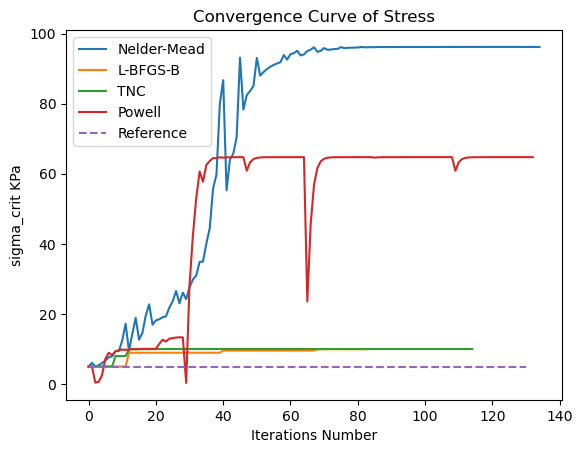

In [238]:
plt.plot(sigma_converge_space_NM,label='Nelder-Mead')
plt.plot(sigma_converge_space_BFGS, label = 'L-BFGS-B')
plt.plot(sigma_converge_space_TNC,label = 'TNC')
plt.plot(sigma_converge_space_Powell,label = 'Powell')

plt.plot([0,130],[4.969,4.969],'--',label='Reference')
plt.xlabel('Iterations Number')
plt.ylabel('sigma_crit KPa')
plt.title('Convergence Curve of Stress')
plt.legend()

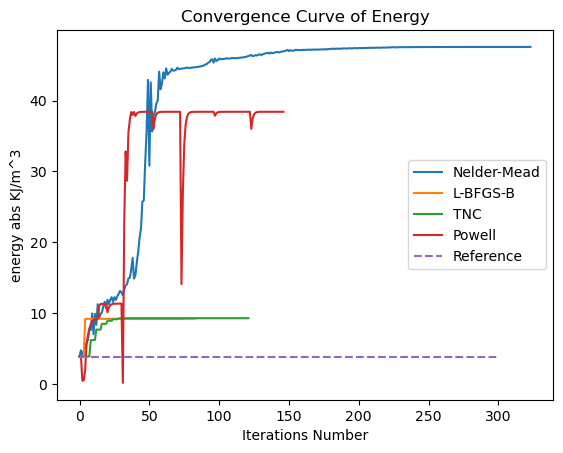

In [239]:
plt.plot(energy_converge_space_NM,label='Nelder-Mead')
plt.plot(energy_converge_space_BFGS,label='L-BFGS-B')
plt.plot(energy_converge_space_TNC,label='TNC')
plt.plot(energy_converge_space_Powell,label='Powell')

plt.plot([0,300],[3.732,3.732],'--',label='Reference')
plt.xlabel('Iterations Number')
plt.ylabel('energy abs KJ/m^3')
plt.title('Convergence Curve of Energy')
plt.legend()